In [1]:
%env OPENBLAS_NUM_THREADS=1
%env OMP_NUM_THREADS=1

env: OPENBLAS_NUM_THREADS=1
env: OMP_NUM_THREADS=1


In [3]:
import os
import argparse

# torch imports
import torch
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
from torchinfo import summary

# HF imports
import diffusers
from diffusers.optimization import get_cosine_schedule_with_warmup
import datasets

# custom imports
from training import train_loop
from eval import evaluate_generation, evaluate_sample_many, evaluate_fake_PIRADS_images, evaluate, SegGuidedDDIMPipeline
from utils import make_grid, save_nifti, load_config, flatten_config, parse_3d_volumes, split_dset_by_patient, get_patient_splits

import yaml
import pickle
import nibabel as nib
from sklearn.model_selection import train_test_split
import monai
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged, NormalizeIntensityd, ToTensord, Orientationd, CenterSpatialCropd, Orientationd, ScaleIntensityRangePercentilesd
from datetime import datetime
from tqdm.auto import tqdm


/home/lc2382/.conda/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def load_config(config_file):
    """Load a YAML configuration file and return a nested dictionary."""
    with open(config_file, "r") as f:
        return yaml.safe_load(f)

def flatten_config(config):
    """
    Merge nested configuration dictionaries into a single flat dictionary.
    
    For each top-level section (e.g., model_args, data_args, etc.), the inner
    dictionary is merged into a single dictionary. If there are duplicate keys,
    later sections will overwrite the earlier ones.
    """
    flat_config = {}
    for section, sub_config in config.items():
        if isinstance(sub_config, dict):
            flat_config.update(sub_config)
        else:
            flat_config[section] = sub_config
    return flat_config

In [5]:
config = flatten_config(load_config('/home/lc2382/project/segmentation-guided-diffusion/config/config_seg_guided_CG+PZ_CFG_ClassCond_CosScheduler_400epochs_cfgweight1.0.yaml'))
print(config)

{'mode': 'train', 'model_type': 'DDIM', 'resume_epoch': None, 'img_size': 128, 'num_img_channels': 1, 'dataset': 'fastMRI_NYU', 'label_csv_dir': '/home/lc2382/project/segmentation-guided-diffusion/data/labels/t2_slice_level_labels_reversed.csv', 'img_dir': '/home/lc2382/project/fastMRI_NYU/nifti', 'seg_dir': '/home/lc2382/project/segmentation-guided-diffusion/data/CG+PZ_seg', 'segmentation_guided': True, 'neighboring_images_guided': True, 'segmentation_channel_mode': 'single', 'num_segmentation_classes': 3, 'train_batch_size': 32, 'eval_batch_size': 16, 'num_epochs': 400, 'gradient_accumulation_steps': 1, 'learning_rate': 1e-05, 'lr_warmup_steps': 500, 'save_image_epochs': 40, 'save_model_epochs': 40, 'mixed_precision': 'fp16', 'class_conditional': True, 'cfg_training': True, 'num_class_embeds': 5, 'output_dir': None, 'save_forward_process': True, 'use_squaredcos_cap_v2_scheduler': True, 'use_ablated_segmentations': False, 'eval_noshuffle_dataloader': False, 'seed': 10383, 'cfg_eval': 

In [6]:
img_dir = "/home/lc2382/project/fastMRI_NYU/nifti"
exclude = ["223"]
train_ids, val_ids, test_ids = get_patient_splits(
    datapath=config['img_dir'],
    test_size=0.3,
    val_size=0.5,
    seed=10383,
    exclude_ids=exclude
)

print(f"[main] splits seed{config.get('seed', 42)}")
print("[main] train ids\n", train_ids)
print("[main] val ids\n", val_ids)
print("[main] test ids\n", test_ids)
print()
print(f"Train: {len(train_ids)} patients")
print(f"val:   {len(val_ids)} patients")
print(f"test:  {len(test_ids)} patients")
print()

# load data
dset_dict = {}
if config['img_dir'] is not None:
    img_paths = [
        os.path.join(root, file)
        for root, _, files in sorted(os.walk(config['img_dir']))
        for file in files if file.endswith("T2W.nii.gz")
    ]
    dset_dict["image"] = img_paths

if config['segmentation_guided']:
    seg_types = os.listdir(config['seg_dir'])
    seg_paths = {
        seg_type: [
            os.path.join(root, file)
            for root, _, files in sorted(os.walk(os.path.join(config['seg_dir'], seg_type)))
            for file in files if file.endswith(".nii.gz")
        ]
        for seg_type in seg_types
    }
    for seg_type in seg_types:
        print("[main] CONDITIONED ON", seg_type)
        seg_key = 'seg_' + seg_type
        dset_dict.update({seg_key: seg_paths[seg_type]})

print(f"[main] {dset_dict.keys()}")

dset_dict_train = split_dset_by_patient(dset_dict, train_ids)
dset_dict_val = split_dset_by_patient(dset_dict, val_ids)
dset_dict_test = split_dset_by_patient(dset_dict, test_ids)

slices_dset_list_train = parse_3d_volumes(dset_dict_train, seg_type, label_csv_file=config['label_csv_dir'])
slices_dset_list_val = parse_3d_volumes(dset_dict_val, seg_type, label_csv_file=config['label_csv_dir'])
slices_dset_list_test = parse_3d_volumes(dset_dict_test, seg_type, label_csv_file=config['label_csv_dir'])


[main] splits seed10383
[main] train ids
 ['094', '042', '161', '087', '279', '108', '082', '123', '240', '165', '097', '118', '145', '047', '153', '196', '053', '026', '294', '290', '154', '036', '023', '210', '050', '091', '090', '259', '194', '233', '296', '078', '105', '009', '051', '214', '010', '192', '103', '238', '098', '020', '190', '136', '121', '189', '171', '077', '032', '049', '001', '160', '046', '104', '207', '178', '297', '005', '228', '293', '086', '022', '183', '175', '025', '006', '135', '100', '312', '137', '250', '088', '239', '199', '162', '182', '107', '251', '280', '260', '133', '035', '152', '170', '289', '221', '101', '168', '166', '111', '285', '282', '015', '045', '127', '138', '062', '116', '126', '211', '004', '065', '054', '203', '298', '269', '306', '040', '141', '041', '106', '072', '209', '212', '261', '179', '027', '109', '148', '277', '267', '262', '245', '149', '191', '284', '080', '061', '268', '029', '151', '066', '304', '193', '144', '305', '033'

In [7]:
norm_key, tot_key = [], []
if config['img_dir'] is not None:
    norm_key.append('image')
    tot_key.append('image')

if config['segmentation_guided']:
    tot_key.append(seg_key)

if config['neighboring_images_guided']:
    tot_key.append('clean_left')
    tot_key.append('clean_right')
    norm_key.append('clean_left')
    norm_key.append('clean_right')

train_transforms = Compose([

    # Add a channel dimension to 'image' and 'segm'
    EnsureChannelFirstd(keys=tot_key, channel_dim='no_channel'),

    Orientationd(keys=tot_key, axcodes='LAS'),

    # center spatial crop
    CenterSpatialCropd(keys=tot_key, roi_size=(128, 128)),

    # scale to [0, 1]
    ScaleIntensityRangePercentilesd(
        keys=norm_key,
        lower=2.5, upper=97.5, 
        b_min=0.0, b_max=1.0, 
        clip=True, relative=False, 
        channel_wise=False
    ),
    
    # normalize
    NormalizeIntensityd(
        keys=norm_key,
        subtrahend=0.5,
        divisor=0.5
    ),
    
    # Convert 'image' and 'segm' to PyTorch tensors
    ToTensord(keys=tot_key)
])

eval_transforms = Compose([

    # Add a channel dimension to 'image' and 'segm'
    EnsureChannelFirstd(keys=tot_key, channel_dim='no_channel'),

    Orientationd(keys=tot_key, axcodes='LAS'),
    
    # center spatial crop
    CenterSpatialCropd(keys=tot_key, roi_size=(config['img_size'], config['img_size'])),

    # scale to [0, 1]
    ScaleIntensityRangePercentilesd(
        keys=norm_key,
        lower=1.0, upper=99.0, 
        b_min=0.0, b_max=1.0, 
        clip=True, relative=False, 
        channel_wise=False
    ),
    
    # normalize
    NormalizeIntensityd(
        keys=norm_key,
        subtrahend=0.5,
        divisor=0.5
    ),

    # Convert 'image' and 'segm' to PyTorch tensors
    ToTensord(keys=tot_key)
])

train_dataset = monai.data.Dataset(slices_dset_list_train, transform=train_transforms)
val_dataset = monai.data.Dataset(slices_dset_list_val, transform=eval_transforms)
test_dataset = monai.data.Dataset(slices_dset_list_test, transform=eval_transforms)

print(f"Length of train_dataset is {len(train_dataset)}")
print(f"Length of val_dataset is {len(val_dataset)}")
print(f"Length of test_dataset is {len(test_dataset)}")

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=config['train_batch_size'], 
    shuffle=True
)

eval_dataloader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=config['eval_batch_size'],
    shuffle=False
)

Length of train_dataset is 3695
Length of val_dataset is 797
Length of test_dataset is 770


axcodes ('LAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (320, 320), channels = 1,please make sure the input is in the channel-first format.


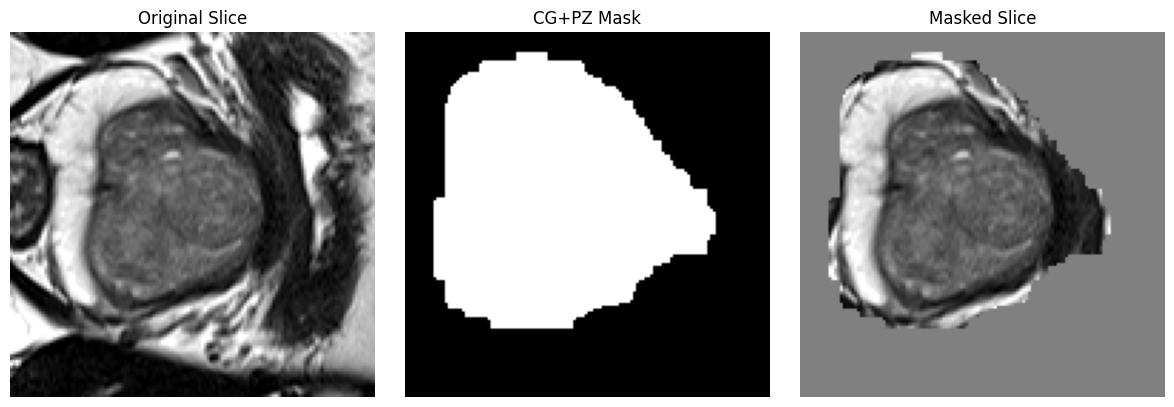

In [14]:
import matplotlib.pyplot as plt

# Grab one batch
batch = next(iter(train_dataloader))
imgs = batch['image']                   # (B,1,H,W)
segs = batch['seg_CG+PZ_lambd0.4']      # (B,1,H,W)

# Take the first sample in the batch
img  = imgs[0, 0].cpu().numpy()         # (H, W)
mask = (segs[0, 0] > 0).cpu().numpy()   # binary mask (H, W)
masked = img * mask                     # masked image

# Plot side by side
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(img,   cmap='gray')
axes[0].set_title('Original Slice')
axes[0].axis('off')

axes[1].imshow(mask,  cmap='gray')
axes[1].set_title('CG+PZ Mask')
axes[1].axis('off')

axes[2].imshow(masked, cmap='gray')
axes[2].set_title('Masked Slice')
axes[2].axis('off')

plt.tight_layout()
plt.show()


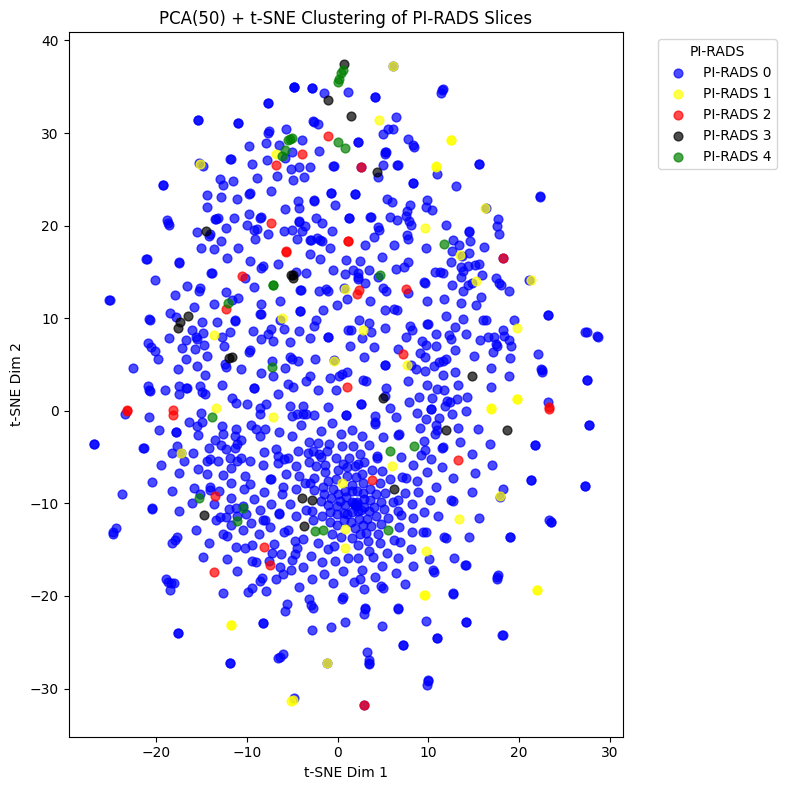

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# — assume you’ve already run your “train_dataloader = DataLoader(train_dataset, …)” code above —

# 1) collect up to N samples
max_samples = 1000
features = []
labels   = []
count = 0

for batch in train_dataloader:
    # print(batch.keys())
    imgs = batch['image']           # (B, C, H, W)
    segs = batch['seg_CG+PZ_lambd0.4']
    lbs  = batch['class_label']           # (B,)
    B = imgs.shape[0]

    mask = (segs > 0).float()  # (B,1,H,W)

    # apply mask so background is zeroed out
    imgs_masked = imgs * mask   # (B,1,H,W)
    
    # flatten each image to a vector
    flat = imgs_masked.view(B, -1).cpu().numpy()
    features.append(flat)
    labels.append(lbs.cpu().numpy())

    count += B
    if count >= max_samples:
        break

features = np.concatenate(features, axis=0)[:max_samples]
labels   = np.concatenate(labels,   axis=0)[:max_samples]

# 2) run t‑SNE
tsne = TSNE(n_components=2, random_state=42)
emb  = tsne.fit_transform(features)   # (max_samples, 2)

color_map = {
    0: 'blue',
    1: 'yellow',
    2: 'red',
    3: 'black',
    4: 'green',
}

# 3) plot
plt.figure(figsize=(8, 8))
for cls, color in color_map.items():
    idx = labels == cls
    plt.scatter(
        emb[idx, 0],
        emb[idx, 1],
        c=color,
        label=f'PI‑RADS {cls}',
        alpha=0.7,
        s=40
    )

plt.legend(title='PI‑RADS', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PCA(50) + t‑SNE Clustering of PI‑RADS Slices')
plt.xlabel('t‑SNE Dim 1')
plt.ylabel('t‑SNE Dim 2')
plt.tight_layout()
plt.show()
